<a href="https://colab.research.google.com/github/AndrewstheBuilder/VideoSemanticSearch_JiuJitsu/blob/main/LabelData_VideoSemanticSearch_JiuJitsu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yt-dlp opencv-python
import yt_dlp
import cv2
import numpy as np
import os

def stream_video_and_extract_frames(url, output_folder, interval=1):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    ydl_opts = {
        'format': 'bestvideo[ext=mp4][height<=360]/best',  # Limit video to 480p or lower to save space
        'quiet': True,
    }

    # Initialize the YoutubeDL object
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        # Get video info and stream the video using yt-dlp
        video_info = ydl.extract_info(url, download=False)
        video_url = video_info['url']

        # Open video stream with OpenCV
        cap = cv2.VideoCapture(video_url)
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        frame_rate = round(frame_rate)
        frame_count = 0
        success = True

        while success:
            success, frame = cap.read()
            if not success:
                break
            # Save every N-th frame (based on interval)
            if frame_count % (frame_rate * interval) == 0:
                frame_filename = os.path.join(output_folder, f"frame_{frame_count:04d}.jpg")
                cv2.imwrite(frame_filename, frame)
            frame_count += 1

        cap.release()
        print(f"Extracted frames to {output_folder}")

# List of YouTube links
# Say for None class we get 50 each and we need 1000
# We will use about 15 videos
youtube_links = [
    # "https://www.youtube.com/watch?v=sefzIs9kzvA",
    # "https://www.youtube.com/watch?v=lJ7D-mWEiEA",
    # "https://www.youtube.com/watch?v=lCJWF5MaKJw",
    # "https://www.youtube.com/watch?v=YKv-roG9BW4",
    # "https://www.youtube.com/watch?v=8o6JcJZudfk",
    # "https://www.youtube.com/watch?v=U0hCqDjFj4g",
    # "https://www.youtube.com/watch?v=eeuHRn_1FsE",
    # "https://www.youtube.com/watch?v=-Xxmmhc4U1s",
    # "https://www.youtube.com/watch?v=Rk1wm0AdDzU",
    # "https://www.youtube.com/watch?v=w8uk0f3eK48",
    # "https://youtu.be/VdvzKLjdd8c?si=5YQAycPVbciF9a2S",
    # "https://youtu.be/KALD099h5JQ?si=XO-Vc41vPOrzYJyO",
    # "https://youtu.be/QppO6J99OKs?si=MbgKFqtgCR0UTzJR",
    # "https://youtu.be/vXL05xZMf_c?si=q3Menv_nXM_h5QeL",
    # "https://youtu.be/gF4eJEPNAu8?si=umQS2PcjEfJv781M",
    # "https://www.youtube.com/watch?v=f4XwLqDkxdI"
    # Add more YouTube video links here
]

# Base output directory for saving frames
base_output_folder = "/content/youtube_videos_frames"

# Loop through each YouTube link and extract frames
for idx, youtube_link in enumerate(youtube_links):
    # Create a unique folder for each video based on its index
    output_folder = os.path.join(base_output_folder, f"video_{idx+1}")

    # Extract frames for the current video
    stream_video_and_extract_frames(youtube_link, output_folder, interval=1)

Extracted frames to /content/youtube_videos_frames/video_1


In [ ]:
!zip -r /content/15_video_frames.zip ./youtube_videos_frames

Streaming output truncated to the last 5000 lines.
  adding: youtube_videos_frames/video_5/frame_19740.jpg (deflated 0%)
  adding: youtube_videos_frames/video_5/frame_7350.jpg (deflated 0%)
  adding: youtube_videos_frames/video_5/frame_11340.jpg (deflated 0%)
  adding: youtube_videos_frames/video_5/frame_18210.jpg (deflated 1%)
  adding: youtube_videos_frames/video_5/frame_26640.jpg (deflated 0%)
  adding: youtube_videos_frames/video_5/frame_22890.jpg (deflated 0%)
  adding: youtube_videos_frames/video_5/frame_18090.jpg (deflated 1%)
  adding: youtube_videos_frames/video_5/frame_26370.jpg (deflated 0%)
  adding: youtube_videos_frames/video_5/frame_17670.jpg (deflated 1%)
  adding: youtube_videos_frames/video_5/frame_27690.jpg (deflated 1%)
  adding: youtube_videos_frames/video_5/frame_19860.jpg (deflated 0%)
  adding: youtube_videos_frames/video_5/frame_14850.jpg (deflated 1%)
  adding: youtube_videos_frames/video_5/frame_14580.jpg (deflated 0%)
  adding: youtube_videos_frames/video_5/

In [3]:
!unzip /content/trainset_video_frames\(2\).zip

Streaming output truncated to the last 5000 lines.
  inflating: youtube_videos_frames/video_2/frame_6180.jpg  
  inflating: youtube_videos_frames/video_2/frame_6210.jpg  
  inflating: youtube_videos_frames/video_2/frame_6240.jpg  
  inflating: youtube_videos_frames/video_2/frame_6270.jpg  
  inflating: youtube_videos_frames/video_2/frame_6300.jpg  
  inflating: youtube_videos_frames/video_2/frame_6330.jpg  
  inflating: youtube_videos_frames/video_2/frame_6360.jpg  
  inflating: youtube_videos_frames/video_2/frame_6390.jpg  
  inflating: youtube_videos_frames/video_2/frame_6420.jpg  
  inflating: youtube_videos_frames/video_2/frame_6450.jpg  
  inflating: youtube_videos_frames/video_2/frame_6480.jpg  
  inflating: youtube_videos_frames/video_2/frame_6510.jpg  
  inflating: youtube_videos_frames/video_2/frame_6540.jpg  
  inflating: youtube_videos_frames/video_2/frame_6570.jpg  
  inflating: youtube_videos_frames/video_2/frame_6600.jpg  
  inflating: youtube_videos_frames/video_2/frame_

In [1]:
# TODO:
# 2. read in CSV and populate the datastructure I am going to be adding the label data to
import csv
labels_file_read = "frame_labels(5).csv"
labels = {}

# Read existing labels from CSV file and populate the labels dictionary
try:
    with open(labels_file_read, mode='r', newline='') as file:
        reader = csv.DictReader(file)
        for row in reader:
            frame = row['Frame']
            label = row['Label']
            labels[frame] = label
except FileNotFoundError:
    # If the file doesn't exist, start with empty labels
    print(f"No existing labels found. Starting fresh.")

In [2]:
labels

{'/content/youtube_videos_frames/video_1/frame_0000.jpg': 'none',
 '/content/youtube_videos_frames/video_1/frame_0030.jpg': 'none',
 '/content/youtube_videos_frames/video_1/frame_0060.jpg': 'none',
 '/content/youtube_videos_frames/video_1/frame_0120.jpg': 'none',
 '/content/youtube_videos_frames/video_1/frame_0150.jpg': 'none',
 '/content/youtube_videos_frames/video_1/frame_0180.jpg': 'none',
 '/content/youtube_videos_frames/video_1/frame_0210.jpg': 'none',
 '/content/youtube_videos_frames/video_1/frame_0240.jpg': 'none',
 '/content/youtube_videos_frames/video_1/frame_0270.jpg': 'none',
 '/content/youtube_videos_frames/video_1/frame_0300.jpg': 'none',
 '/content/youtube_videos_frames/video_1/frame_0330.jpg': 'none',
 '/content/youtube_videos_frames/video_1/frame_0360.jpg': 'none',
 '/content/youtube_videos_frames/video_1/frame_0390.jpg': 'none',
 '/content/youtube_videos_frames/video_1/frame_0420.jpg': 'none',
 '/content/youtube_videos_frames/video_1/frame_0450.jpg': 'none',
 '/content

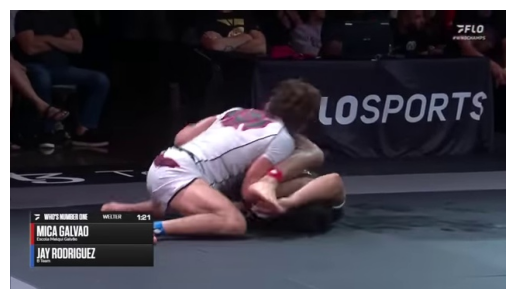

Displaying frame 1724/12043: /content/youtube_videos_frames/video_10/frame_31350.jpg


Label saved for frame /content/youtube_videos_frames/video_10/frame_31350.jpg: guarded
All labels saved to frame_labels.csv


In [4]:
# TODO
# 1. start at the frame I left off at
import os
import cv2
import ipywidgets as widgets
from IPython.display import display, clear_output
import csv
import matplotlib.pyplot as plt
import re

# Function to extract frame number from filename
def extract_frame_number(filename):
    """Extracts the frame number from the filename (assumes the format frame_XXXX.jpg)."""
    match = re.search(r"frame_(\d+)\.jpg", filename)
    return int(match.group(1)) if match else -1

# Base output directory for saving frames
base_output_folder = "/content/youtube_videos_frames"
# Initialize variables
output_folder = "/content/youtube_videos_frames"

# Traverse subdirectories and gather frame paths
frame_list = []
for root, dirs, files in os.walk(base_output_folder):
    for file in files:
        if file.endswith('.jpg'):
            frame_list.append(os.path.join(root, file))

# Updated sorting of frame_list based on frame number
frame_list = sorted(frame_list, key=lambda f: (os.path.basename(os.path.dirname(f)), extract_frame_number(f)))

current_index = 1724
labels_file = "frame_labels.csv"  # To save the labels
# labels = {}

# Create widgets
label_dropdown = widgets.Dropdown(
    options=['standing', 'pinning', 'guarded', 'none'],
    value='none',
    description='Label:'
)
next_button = widgets.Button(description="Next Frame")
prev_button = widgets.Button(description="Previous Frame")
save_button = widgets.Button(description="Save Label")
save_to_csv = widgets.Button(description="Save to CSV")

# Function to display the current frame
def display_frame(index):
    clear_output(wait=True)
    frame_path = frame_list[index]
    frame = cv2.imread(frame_path)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Display frame
    plt.imshow(frame_rgb)
    plt.axis('off')
    plt.show()

    # Show current index and label
    print(f"Displaying frame {index+1}/{len(frame_list)}: {frame_path}")
    display(widgets.HBox([prev_button, next_button, save_button, save_to_csv, label_dropdown]))

# Function to save the current label
def save_label(b):
    global current_index
    labels[frame_list[current_index]] = label_dropdown.value
    print(f"Label saved for frame {frame_list[current_index]}: {label_dropdown.value}")

# Function to go to the next frame
def next_frame(b):
    global current_index
    if current_index < len(frame_list) - 1:
        current_index += 1
        display_frame(current_index)

# Function to go to the previous frame
def prev_frame(b):
    global current_index
    if current_index > 0:
        current_index -= 1
        display_frame(current_index)

# Initial display
display_frame(current_index)

# Function to save all labels to a CSV file
def save_labels_to_csv(b=None):
    with open(labels_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Frame", "Label"])
        for frame, label in labels.items():
            writer.writerow([frame, label])
    print(f"All labels saved to {labels_file}")

# Optionally save all labels to CSV when done
# save_labels_to_csv()

# Attach button events
next_button.on_click(next_frame)
prev_button.on_click(prev_frame)
save_button.on_click(save_label)
save_to_csv.on_click(save_labels_to_csv)
# stopped at 1724 frame


In [ ]:
# Organize video frames into sub directories corresponding to classes
import pandas as pd

# Load the csv with the labels
labels_df = pd.read_csv('/content/frame_labels.csv')
# labels_df.front()

# Define the base dataset directory in Colab
dataset_dir = '/content/dataset/'

# Ensure the class directories exist (lowercase class names)
classes = ['none', 'standing', 'pinning', 'guarded']
for class_name in classes:
    os.makedirs(os.path.join(dataset_dir, class_name), exist_ok=True)

In [ ]:
import shutil
# Function to copy files based on the CSV labels
def copy_files_to_class_directories(df, base_dir):
    for _, row in df.iterrows():
        frame_path = row['Frame']
        label = row['Label']
        class_dir = os.path.join(base_dir, label)

        # Ensure the frame path exists and copy the file
        if os.path.exists(frame_path):
            shutil.copy(frame_path, class_dir)
        else:
            print(f"File {frame_path} does not exist.")

# Copy files into the respective directories based on the CSV
copy_files_to_class_directories(labels_df, dataset_dir)

print(f"Files have been copied into class directories under {dataset_dir}.")

Files have been copied into class directories under /content/dataset/.


In [ ]:
!zip -r /content/testset.zip ./dataset

  adding: dataset/ (stored 0%)
  adding: dataset/guarded/ (stored 0%)
  adding: dataset/guarded/frame_5490.jpg (deflated 2%)
  adding: dataset/guarded/frame_5310.jpg (deflated 1%)
  adding: dataset/guarded/frame_6480.jpg (deflated 2%)
  adding: dataset/guarded/frame_6840.jpg (deflated 1%)
  adding: dataset/guarded/frame_3240.jpg (deflated 1%)
  adding: dataset/guarded/frame_6930.jpg (deflated 1%)
  adding: dataset/guarded/frame_4680.jpg (deflated 1%)
  adding: dataset/guarded/frame_7290.jpg (deflated 1%)
  adding: dataset/guarded/frame_4950.jpg (deflated 1%)
  adding: dataset/guarded/frame_7200.jpg (deflated 2%)
  adding: dataset/guarded/frame_8190.jpg (deflated 2%)
  adding: dataset/guarded/frame_1890.jpg (deflated 1%)
  adding: dataset/guarded/frame_4860.jpg (deflated 1%)
  adding: dataset/pinning/ (stored 0%)
  adding: dataset/pinning/frame_3420.jpg (deflated 2%)
  adding: dataset/pinning/frame_5580.jpg (deflated 1%)
  adding: dataset/pinning/frame_2160.jpg (deflated 1%)
  adding: d